In [2]:
import pandas as pd
import numpy as np
import sklearn
import datetime
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.decomposition import NMF
from annoy import AnnoyIndex
import pickle

In [5]:
import pandas as pd

# Reading ratings file
rating_dt = pd.read_csv('/Users/mikhailpinto/Downloads/Sem 2/IST707 - AML/Project/Movie Rec Data/rating.csv', sep=',', encoding='latin-1', usecols=['userId','movieId','rating','timestamp'])

# Reading movies file
movie_dt = pd.read_csv('/Users/mikhailpinto/Downloads/Sem 2/IST707 - AML/Project/Movie Rec Data/movie.csv', sep=',', encoding='latin-1', usecols=['movieId','title','genres'])
print(rating_dt.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB
None


In [6]:
# randomly select 20% users from rating dataset 
user_ids = rating_dt["userId"].unique().tolist() 
num_all_user = len(user_ids)

np.random.seed(123)
rand_userid = np.random.choice(user_ids, size = int(num_all_user * 0.1), replace=False)
sample_df = rating_dt.loc[rating_dt['userId'].isin(rand_userid)]

sample_df.head()

,userId,movieId,rating,timestamp
236,3,1,4.0,1999-12-11 13:36:47
237,3,24,3.0,1999-12-14 12:54:08
238,3,32,4.0,1999-12-11 13:14:07
239,3,50,5.0,1999-12-11 13:13:38
240,3,160,3.0,1999-12-14 12:54:08


In [7]:
# pivot movie, user, rating dataframe into compressed matrix
def movie_use_matrix_pivot(df_):
    mu_matrix = df_.pivot(index = 'userId', 
                          columns = 'movieId', 
                          values = 'rating').fillna(0)
    # compress original matrix
    mu_matrix_cp = csr_matrix(mu_matrix.values)
    return mu_matrix, mu_matrix_cp
# get rating matrix
rating_matrix, rating_matrix_cp = movie_use_matrix_pivot(sample_df)

In [8]:
# Implement Non negative matrix factorization to find the item latent factors
# input: number of latent factors - dimension; compressed rating matrix - data
# output: return the item latent factors
def get_item_latent_factor(dimension, matrix_cp):
    nmf_model = NMF(n_components=dimension)     # starts with 20 latents factors
    # Matrix factorization               # V ~ W.H  (Find two non-negative matrices (W, H) whose product approximates the non- negative matrix X. )
    nmf_model.fit(matrix_cp)     # R can be array-like or sparse, here it is array-like (dense)
    item_vectors = nmf_model.components_.T         # item latent factors
    return item_vectors

In [9]:
# get rmse on test set
# input: data and number of factors
# output: rmse
from surprise.model_selection import cross_validate
from surprise import NMF as surprise_nmf
from surprise.accuracy import rmse
from surprise import accuracy
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import train_test_split as surprise_train_test_split
def get_nmf_rmse(sample_data, num_factors):
    reader = Reader(rating_scale=(0, 5))
    data = Dataset.load_from_df(sample_data[['userId', 'movieId', 'rating']], reader)
    trainset, testset = surprise_train_test_split(data, test_size=0.2)
    algo = surprise_nmf(n_factors = num_factors)
    predictions = algo.fit(trainset).test(testset)
    accuracy.rmse(predictions)

In [10]:
# tuning number of factors with cv
# mean_scores = [0.9173990498169124, 0.90017791088623, 0.9006444171555912, 0.9094033122784755, 0.9208407704724129]
# choose num_factors = 14
mean_scores = []
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(sample_df[['userId', 'movieId', 'rating']], reader)
num = [10, 14, 18, 22, 26]
for n in [10, 14, 18, 22, 26]:
    nmf_model = surprise_nmf(n_factors = n)
    score = cross_validate(nmf_model, data, measures=['RMSE'], cv=3, verbose=False)['test_rmse']
    mean_scores.append(score.mean())

In [11]:
mean_scores

[0.8945355139888589,
 0.8767086063419502,
 0.877818999435385,
 0.8880521810903276,
 0.9019924590470034]

In [12]:
# in test set: RMSE: 0.8846
get_nmf_rmse(sample_df, 14)

RMSE: 0.8716


In [13]:
# in test set: RMSE: 0.8921 
get_nmf_rmse(sample_df, 20)
# in test set: RMSE: 0.9239
get_nmf_rmse(sample_df, 30)
# in test set: RMSE: 0.9050
get_nmf_rmse(sample_df, 10)
# in test set: RMSE: 0.8858
get_nmf_rmse(sample_df, 15)

RMSE: 0.8800
RMSE: 0.9141
RMSE: 0.8907
RMSE: 0.8730


[Text(0.5, 0, 'Number of Latent Factors in NMF'),
 Text(0, 0.5, 'CV rmse'),
 Text(0.5, 1.0, '3-Fold CV')]

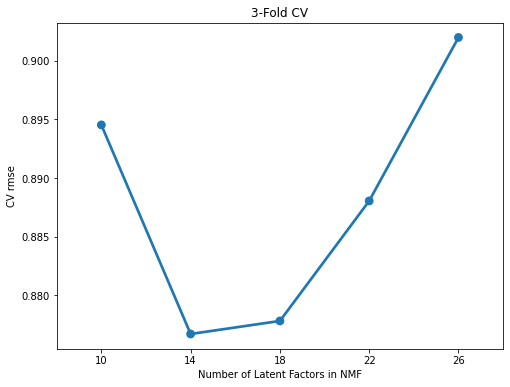

In [14]:
#num = [10, 14, 18, 22, 26]
#mean_scores = [0.9173990498169124, 0.90017791088623, 0.9006444171555912, 0.9094033122784755, 0.9208407704724129]
cv_result_df = pd.DataFrame({'cv_rmse': mean_scores, 'n_factors': num})

fig, ax = plt.subplots(figsize=(8, 6))
sns.pointplot(x=cv_result_df.n_factors, y=cv_result_df.cv_rmse, ax=ax)
ax.set(xlabel='Number of Latent Factors in NMF', ylabel='CV rmse', title='3-Fold CV')

In [16]:
# save the best NMF model (nu_components 14)
nmf_model = NMF(n_components=14)     
nmf_model.fit(rating_matrix_cp)  
filename = 'nmf_model.sav'
pickle.dump(nmf_model, open(filename, 'wb'))
loaded_model = pickle.load(open(filename, 'rb'))
item_vector = loaded_model.components_.T

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


OSError: [Errno 30] Read-only file system: 'nmf_model.sav'

In [17]:
filename = 'nmf_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
item_vector = loaded_model.components_.T

FileNotFoundError: [Errno 2] No such file or directory: 'nmf_model.sav'

In [18]:
item_vector

NameError: name 'item_vector' is not defined

In [ ]:
pickle.dump(item_vector, open('item_list', 'wb'))

In [ ]:
# Implement Approximate Nearest Neighborhood to find similar items, save it in 'rating.ann' 
# input: target movie, rating matrix, item_vectors, metric (can be "angular", "euclidean", "manhattan", "hamming")
#        number of trees(More trees gives higher precision when querying)
# output: save it in 'rating.ann' 
def ann(matrix, item_vectors, metric, num_trees):
    # construct a dictionary where movied id contains its vector representation 
    movieids = matrix.columns.tolist()
    rating_dictionary = {movieids[i]: item_vectors[i] for i in range(len(movieids))} 
    # ann method
    f = len(item_vectors[1])
    t = AnnoyIndex(f, metric)  # Length of item vector that will be indexed
    for key in rating_dictionary:
        t.add_item(key, rating_dictionary.get(key))
    t.build(num_trees) # 10 trees
    t.save('rating.ann')

In [ ]:
# find similar items given the targeted movies
# input: f is the length of item vector that will be indexed, top_n - n closed movies 
# output: a 2 element tuple with two lists in it,
#        the first one top_n similar movies from closer to further away from the target movies 
#        the second one containing all corresponding distances
def get_similar_movies(f, target, metric, top_n):
    u = AnnoyIndex(f, metric)
    u.load('rating.ann') # super fast, will just mmap the file
    movies, distances = u.get_nns_by_item(target, top_n, include_distances=True) 
    return movies[1:], distances[1:]

In [ ]:
# input: rating dataset, userid, a rating threshold, movies that are rated below threshold
# will not be counted 
# output: a list of high-scored movies that are rated by givern user, a list of corresponding ratings
#
def get_rated_movies(data, userid, threshold=2):
    all_rates = data[data['userId'] == userid]
    high_rates = all_rates[all_rates['rating'] >= threshold]['rating'].values
    high_rate_movie = all_rates[all_rates['rating'] >= threshold]['movieId'].values
    return high_rate_movie, high_rates

In [ ]:
# get recommendation list for each user in the data set
# input: data - orginal dataframe; dimension - number of latent factors in NMF; matrix_cp - compressed rating matrix;
#        matrix - rating matrix; metric - distance metric in ANN method; num_tree - number of trees in ANN;
#        threshold - rating threshold; top_n - most n similar movies
# output: return a recommendation lsit for each user, each list consists of at most 20 movies.
def get_recommendation(data, dimension, matrix_cp, matrix, metric, num_tree, threshold, top_n):
    userIds = data.userId.unique()
    v = get_item_latent_factor(dimension, rating_matrix_cp)
    ann(matrix, v, metric, num_tree)     # save the ann in 'rating.ann' file
    f = len(v[1])
    u = AnnoyIndex(f, metric)
    u.load('rating.ann')
    # construct the recommendation list for each user
    recommendation_dict = {}
    for userid in userIds:
        high_rate_movie, rate = get_rated_movies(data, userid, threshold)
        movielist = []
        distancelist = []
        if len(high_rate_movie) > 1:
            # find neighborhood of each movies in the high rated movie set
            for movieid in high_rate_movie:
                movie, dist = u.get_nns_by_item(movieid, top_n, include_distances=True)
                movielist.extend(movie[1:])
                # get the weighted distance based on rating scores
                weighted_dist = (np.array(dist[1:])/rate[np.where(high_rate_movie == movieid)]).tolist()
                distancelist.extend(weighted_dist)  
            #if more than 20 movies are chosen to recommend to user, choose 20 nearest item for this user
            if len(movielist) > 20:
                sorted_recommend = np.array(movielist)[np.array(distancelist).argsort()]
                movielist = sorted_recommend[:20]
        recommendation_dict[userid] = movielist
    return recommendation_dict

In [ ]:
# one set of hyperparameter output below dictionary
res = get_recommendation(sample_df, 20, rating_matrix_cp, rating_matrix, 'angular', 10, 2, 10)

In [ ]:
# calculate hit rate
def get_hitrate(data, dimension, matrix_cp, matrix, metric, num_tree, threshold, top_n):
    userIds = data.userId.unique()
    v = get_item_latent_factor(dimension, rating_matrix_cp)
    ann(matrix, v, metric, num_tree)     # save the ann in 'rating.ann' file
    f = len(v[1])
    u = AnnoyIndex(f, metric)
    u.load('rating.ann')
    hit = 0
    total = 0
    for userid in userIds:
        high_rate_movie, rate = get_rated_movies(data, userid, threshold)
        movielist = []
        distancelist = []
        if len(high_rate_movie) > 1:
            token = np.random.randint(len(high_rate_movie))
            l = high_rate_movie[token]
            new_movies = np.delete(high_rate_movie, [token])
            new_ratings = np.delete(rate, [token])
            # find neighborhood of each movies in the high rated movie set
            for movieid in new_movies:
                movie, dist = u.get_nns_by_item(movieid, top_n, include_distances=True)
                movielist.extend(movie[1:])
                # get the weighted distance based on rating scores
                weighted_dist = (np.array(dist[1:])/new_ratings[np.where(new_movies == movieid)]).tolist()
                distancelist.extend(weighted_dist)  
            #if more than 20 movies are chosen to recommend to user, choose 20 nearest item for this user
            if len(movielist) > 20:
                sorted_recommend = np.array(movielist)[np.array(distancelist).argsort()]
                movielist = sorted_recommend[:20]
            if l in movielist:
                hit += 1
            total += 1
    return hit/total


In [ ]:
# hit rate for different number of trees
# hit_rate_list = [0.04645785918138796, 0.04667461435641776, 0.04793901954409162, 0.04786676781908168, 0.04765001264405188]
trees = [10, 15, 20, 25, 30]
hit_rate_list = []
for tree in trees:
    h = get_hitrate(sample_df, 14, rating_matrix_cp, rating_matrix, 'angular', tree, 3, 10)
    hit_rate_list.append(h)

In [ ]:
hit_rate_list

In [ ]:
trees = [10, 15, 20, 25, 30]
hit_rate_list = [0.04645785918138796, 0.04667461435641776, 0.04793901954409162, 0.04786676781908168, 0.04765001264405188]
cv_result_df2 = pd.DataFrame({'hit_rate': hit_rate_list, 'n_trees': trees})

fig, ax = plt.subplots(figsize=(8, 6))
sns.set_style('whitegrid')
sns.pointplot(x=cv_result_df2.n_trees, y=cv_result_df2.hit_rate, ax=ax)
ax.set(xlabel='Number of Trees', ylabel='Hit Rate', title='Number of Trees in ANN')

In [ ]:
get_hitrate(sample_df, 14, rating_matrix_cp, rating_matrix, 'angular', 20, 3, 10)

In [ ]:
ann(rating_matrix, item_vectors, 'angular', 20)

In [ ]:
hit_rate_list2

In [ ]:
# 0.05299664029478704
get_hitrate(sample_df, 20, rating_matrix_cp, rating_matrix, 'angular', 10, 2, 10)
# 0.05147935406957841
get_hitrate(sample_df, 30, rating_matrix_cp, rating_matrix, 'angular', 10, 2, 10)
# 0.046313355731368085
get_hitrate(sample_df, 40, rating_matrix_cp, rating_matrix, 'angular', 10, 2, 10)
# 0.048336404031646255
get_hitrate(sample_df, 20, rating_matrix_cp, rating_matrix, 'angular', 20, 2, 10)
# 0.04862541093168599
get_hitrate(sample_df, 20, rating_matrix_cp, rating_matrix, 'angular', 30, 2, 10)

In [ ]:
# for example: get the top 10 closest movied to movieid = 20
# get name/title of the movies
v = get_item_latent_factor(20, rating_matrix_cp)
ind, distance = get_similar_movies(20, rating_matrix, v, 'angular', 10, 10)
namelist = []
interested_movie = movie_dt.loc[movie_dt['movieId'] == 20]['title']
for movie in u.get_nns_by_item(20, 10):
     temp = movie_dt.loc[movie_dt['movieId'] == movie]['title']
     namelist.append(temp)
print(f'10 movies that are similar to {interested_movie} are: {namelist}') 

In [ ]:
# display the recommendation list
loaded_model = pickle.load(open(filename, 'rb'))
item_vector = loaded_model.components_.T
def get_recommendation(data, dimension, matrix_cp, matrix, metric, num_tree, threshold, top_n):
    userIds = data.userId.unique()
    v = item_vector
    ann(matrix, v, metric, num_tree)     # save the ann in 'rating.ann' file
    f = len(v[1])
    u = AnnoyIndex(f, metric)
    u.load('rating.ann')
    # construct the recommendation list for each user
    recommendation_dict = {}
    for userid in userIds:
        high_rate_movie, rate = get_rated_movies(data, userid, threshold)
        movielist = []
        distancelist = []
        if len(high_rate_movie) > 1:
            # find neighborhood of each movies in the high rated movie set
            for movieid in high_rate_movie:
                movie, dist = u.get_nns_by_item(movieid, top_n, include_distances=True)
                movielist.extend(movie[1:])
                # get the weighted distance based on rating scores
                weighted_dist = (np.array(dist[1:])/rate[np.where(high_rate_movie == movieid)]).tolist()
                distancelist.extend(weighted_dist)  
            #if more than 20 movies are chosen to recommend to user, choose 20 nearest item for this user
            if len(movielist) > 20:
                sorted_recommend = np.array(movielist)[np.array(distancelist).argsort()]
                movielist = sorted_recommend[:20]
        recommendation_dict[userid] = movielist
    return recommendation_dict
recommendationn_list = get_recommendation(sample_df, 14, rating_matrix_cp, rating_matrix, 'angular', 20, 2, 10)

In [ ]:
client_id = int(np.random.choice(sample_df.userId.unique(), 1))
print(f'recommendation for client: {client_id}')
movies = recommendationn_list[client_id]
movie_dt.loc[movie_dt['movieId'].isin(movies)]

In [ ]:
# find rmse in the current optimal nmf in different user group
user_counts = sample_df.groupby('userId').size()
active_levels = ['<10', '10-20', '20-50', '50-80', '80-150', '>150']

user_counts_levels = dict.fromkeys(active_levels, None)
user_counts_levels['<10'] = user_counts[user_counts < 10]
user_counts_levels['10-20'] = user_counts[(user_counts >= 10) & (user_counts < 20)]
user_counts_levels['20-50'] = user_counts[(user_counts >= 20) & (user_counts < 50)]
user_counts_levels['50-80'] = user_counts[(user_counts >= 50) & (user_counts < 80)]
user_counts_levels['80-150'] = user_counts[(user_counts >= 80) & (user_counts < 150)]
user_counts_levels['>150'] = user_counts[user_counts >= 150]

user_level_rmse = []
for key in active_levels:
    indices = user_counts_levels[key].index.tolist()
    pred_df = sample_df[sample_df['userId'].isin(indices)]
    rmse = get_nmf_rmse(pred_df, 14)
    user_level_rmse.append(rmse)

In [ ]:
# user_level_rmse = [1.2398, 1.1411, 1.0097, 0.9617, 0.9261, 0.8583]
cv_result_df3 = pd.DataFrame({'rmse': user_level_rmse, 'user_count_level': active_levels})

fig, ax = plt.subplots(figsize=(8, 6))
sns.set_style('whitegrid')
sns.pointplot(x=cv_result_df3.user_count_level, y=cv_result_df3.rmse, ax=ax)
ax.set(xlabel='User Count Level', ylabel='RMSE', title='Number of User Rating and RMSE in NMF')

In [ ]:
user_df = sample_df.loc[sample_df['userId'].isin(user_id)]
movies = set(user_df['movieId'])
len(movies)

In [ ]:
recommendationn_list